## Kriging

Kriging is a method of typically spatial interpolation for which the interpolated values are modeled by a Gaussian process governed by prior covariances. Input data are measurement for a quantity $Q$  on some locations $\mathbf{x}_i$ and the objective is to provide an estimate of that quantity $Q$ at given location. 
It is also assumed that the spatial correlation of the quantity in terms of a covariance matrix $C$ is known where
\begin{equation}\label{eqCov}
C(\mathbf{x},\mathbf{y}) = \gamma(h)
\end{equation}
where $h$ is the distance of of the points $\mathbf{x}$ and $\mathbf{y}$ and $\gamma$ is the so called 
variogram which is describing the degree of spatial dependence of a spatial random field $Q(\mathbf{x})$.

<img src="https://vsp.pnnl.gov/help/image/Variogram.gif">

The first task is to estimate the variogram $\gamma$ from the data.
We will do this for the data set [FE.csv](FE.csv) which has three columns, x-position and y-position of
measurement points and the iron content measured at this point. The first three rows of the file containing some
additional information are skipped.

### Reference:
- [Kitanidis, P.K. (1997) Introduction to Geostatistics: Applications in Hydrogeology, Cambridge University Press.](https://www.cambridge.org/gb/academic/subjects/earth-and-environmental-science/hydrology-hydrogeology-and-water-resources/introduction-geostatistics-applications-hydrogeology?format=PB&isbn=9780521587471) 

In [1]:
import numpy as np
#%matplotlib notebook

In [2]:
data=np.loadtxt("./FE.csv", skiprows=3, delimiter=',')
print("number of records =",data.shape)

number of records = (50, 3)


We obtain the arrays of $x$, $y$ and iron content: 

In [3]:
x=data[:,0]
y=data[:,1]
q=data[:,2]
Ndata=x.shape[0]

Lets plot the locations of the measurement points:

In [4]:

import matplotlib.pyplot as plt

plt.figure()
plt.scatter(x, y, s=4)
plt.xlabel('easting[m]')
plt.ylabel('northing[m]')
plt.grid(True)
plt.title("FE score station position")

Text(0.5,1,'FE score station position')

A variogram is estimated based on a so called experimental variogram where the 
interval of possible distances $h$ is subdivided in to bins $B_i$ of constant bin size and 
the following quantity is calculated for each bin:
\begin{equation}\label{eq:EGamma}
\gamma_i = \frac{1}{2N_i} \sum_{(k,l) \in B_i} (q_k-q_l)^2 
\end{equation}
where $(k,l) \in B_i$ means that the distance 
\begin{equation}\label{eq:dist}
h_{kl} = | \mathbf{x}_k-\mathbf{x}_l|^2 
\end{equation}
between the two measurement points $\mathbf{x}_k$ and $\mathbf{x}_l$ is within the bin $B_i$. 
$q_k$ and $q_l$ are the observations at $\mathbf{x}_k$ and $\mathbf{x}_l$.

To implement this we start to find the maximum and minimum distance between two observation points:

In [5]:
hmin=x.max()
hmax=0
for i in range(Ndata):
    for j in range(i+1, Ndata):
        h=np.sqrt((x[i]-x[j])**2+(y[i]-y[j])**2)
        hmin=min(hmin, h)
        hmax=max(hmax, h)

In [6]:
hmin, hmax

(7.0710678118654755, 501.32324901205209)

The minimum distance should be positive!

In [7]:
assert hmin>0

We create `Nbins` =20 bins using `Nbins+1` points:

In [8]:
Nbins=20
bins=np.linspace(hmin, hmax, num=Nbins+1)

the distance between two bin boundaries make the bin size:

In [9]:
bin_size=bins[1]-bins[0]
print("bin size = ",bin_size)

bin size =  24.71260906


The arrays `gamma` and `count` accumulate the values of the summation \eqref{eq:EGamma} and
the number of hits in each bin:

In [10]:
gamma=np.zeros((Nbins,))
count=np.zeros((Nbins,))
for i in range(data.shape[0]):
    for j in range(i+1, data.shape[0]):
        h=np.sqrt((x[i]-x[j])**2+(y[i]-y[j])**2)
        ib=min(int((h-hmin)/bin_size),Nbins-1)
        gamma[ib]+=(q[i]-q[j])**2
        count[ib]+=1

now some rescaling as requested by \eqref{eq:EGamma}

In [11]:
gamma=gamma/count/2

We plot the experimental variogram versus the bin center:

Text(0.5,1,'variogram')

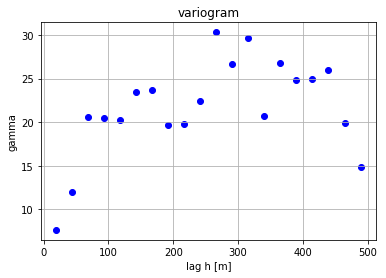

In [12]:
plt.figure()
plt.scatter(bins[:Nbins]+bin_size/2, gamma, c='b', label="experimental")
plt.xlabel("lag h [m]")
plt.ylabel("gamma")
plt.grid(True)
plt.title("variogram")

We need to fit an analytic expression to the experimental variogram. Here we use the exponential variogram
\begin{equation}\label{eq:expvario}
\gamma(h)=s \cdot (1- e^{-\frac{3h}{a}})
\end{equation}
where $a$ is called range and $s$ is called sill.
Let's put this into a function `getVarioGram` for later use:

In [13]:
s=25
a=200
def getVarioGram(h):
    return s-s*np.exp(-h/(a/3))

To visually fit the exponential variogram to experimental variogram we plot both in the same figure:

Text(0.5,1,'variogram')

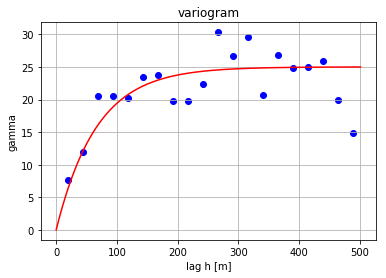

In [14]:
h=np.arange(0, hmax, 1.)
plt.figure()
plt.scatter(bins[:Nbins]+bin_size/2, gamma, c='b', label="experimental")
plt.plot(h, getVarioGram(h), c='r', label="fitted")
plt.xlabel("lag h [m]")
plt.ylabel("gamma")
plt.grid(True)
plt.title("variogram")

The idea of ordinary kriging is to build an estimator for the quantity $Q$ at an arbitrary point  $\mathbf{x}$ using the available 
measurements $q_i$ at points $\mathbf{x}_i$ and the variogram $\gamma$. To this the observations at the observation points $\mathbf{x}_i$
and the prediction point $\mathbf{x}$ are treated as random variables $Q_i$ and $Q$. The approach  is to construct 
an linear estimator $\hat{Q}$ for $Q$:
\begin{equation}\label{eq:EST1}
\hat{Q} = \sum_{i} v_i Q_i
\end{equation}
with unknown coefficients $v_i$. The estimator should be unbiased which means that it preserves the expectation values (ie. $E(Q)=E(Q_i)$)
which leads to the condition 
\begin{equation}\label{eq:EST2}
1 =  \sum_{k} v_k 
\end{equation}
A second condition is that the prediction error of $\hat{Q}$ for $Q$ in form of the variance should be minimal (ie. $\min_{v_0, \ldots v_N} V(Q-\hat{Q})$). The minimization prioblem can be solved using the fact that covariance
of $Q_i$ and $Q_k$ is (in essence) known through the varigram 
\begin{equation}\label{eq:EST3}
C(Q_i,Q_k)=\gamma_{ik} =  \gamma(h_{ij}) \mbox{ with } h_{ij}=|\mathbf{x}_i-\mathbf{x}_j|
\end{equation}
and
\begin{equation}\label{eq:EST4}
C(Q_i,Q)=\gamma_{i} =  \gamma(h_{i}) \mbox{ with } h_{i}=|\mathbf{x}_i-\mathbf{x}|
\end{equation}
The minimization leads to the equations:
\begin{equation}\label{eq:EST5}
\sum_{k} v_k  \gamma_{ik} + \lambda = \gamma_i
\end{equation}
for the coefficients $v_i$ and the Lagrangean multiplier $\lambda$ which is introduced to deal with the fact that the
$v_i$'s are constraint by \eqref{eq:EST2}.
The prediction at $\mathbf{x}$ is then given as
\begin{equation}\label{eq:EST6}
q = \sum_{k} v_k  q_i
\end{equation}
it is also possible to provide an estimation of the standard deviation $\sigma$ as
\begin{equation}\label{eq:EST7}
\sigma^2 = \sum_{k} v_k  \gamma_i + \lambda - \gamma(0)
\end{equation}

To find the $v_i$'s and $\lambda$ we need to solve a system of linear equations 
\begin{equation}\label{eq:SE}
\mathbf{A} \mathbf{u} =\mathbf{b}
\end{equation}
for the unknown vector 
\begin{equation}\label{eq:SOL}
\mathbf{u} =
\begin{bmatrix}
v_0 \\
v_1 \\
\vdots \\
v_{N-1} \\
\lambda
\end{bmatrix}
\end{equation}
the right hand side vector 
\begin{equation}\label{eq:RHS}
\mathbf{b} =
\begin{bmatrix}
\gamma_0 \\
\gamma_1 \\
\vdots \\
\gamma_{N-1} \\
1
\end{bmatrix}
\end{equation}
and 
\begin{equation}\label{eq:A}
\mathbf{A} =
\begin{bmatrix}
\gamma_{00}  & \gamma_{01} & \ldots & \gamma_{0(Ndata-1)} & 1 \\
\gamma_{10}  & \gamma_{11} & \ldots & \gamma_{1(Ndata-1)} & 1 \\
\vdots       &  & \ddots      & \vdots  &1 \\
\gamma_{(Ndata-1)0}  & \gamma_{(Ndata-1)1} & \ldots & \gamma_{(Ndata-1)(Ndata-1)} & 1 \\
1  & 1 & \ldots & 1& 0 \\
\end{bmatrix}
\end{equation}



Set up the matrix:

In [15]:
A=np.zeros((Ndata+1, Ndata+1)) # matrix

for i in range(Ndata):
    for j in range(Ndata):
        h_ij=np.sqrt((x[j]-x[i])**2+(y[j]-y[i])**2)
        A[i,j]=getVarioGram(h_ij)
A[Ndata,:Ndata]=1
A[:Ndata,Ndata]=1

and the right hand side for an estimator at point $\mathbf{x}=(x_e, y_e)=(200, 200)$:

In [16]:
xe, ye= 200, 200
b=np.zeros((Ndata+1,))  # right hand side 
for i in range(Ndata):
    h_i=np.sqrt((xe-x[i])**2+(ye-y[i])**2)
    b[i]=getVarioGram(h_i)
b[Ndata]=1

Solve the linear system using the `np.linalg.solve` function

In [17]:
u=np.linalg.solve(A,b)    

Extract the coefficient vector from the solution:

In [18]:
v=u[:Ndata]

The prediction at point  $\mathbf{x}=(x_e, y_e)$ is then the dot product of the coefficient vector `v` with the data vector `q`:

In [19]:
np.dot(v,q), q.min(), q.max()

(37.309534315726872, 24.399999999999999, 44.100000000000001)

and then we can calculate the estimated error:

In [20]:
np.sqrt(np.dot(v,b[:Ndata])+u[Ndata]-getVarioGram(0))

3.1370537368032783

Now we want to create a 2D plot of the estimated iron content and the corresponding error.
For this we create a grid with gridlines at `xg` and `yg` with spacing `dx`:

In [21]:
dx=10
xg=np.arange(0, 500., dx)
yg=np.arange(0, 500., dx)

We create arrays to hold the values for the prection and the the variance $\sigma^2$

In [22]:
var=np.zeros((len(yg), len(xg)))
qe=np.zeros((len(yg), len(xg)))

And then we can repeat the work flow which we have already developed for each grid point: 

In [23]:
for k in range(len(xg)):
  for l in range(len(yg)):
        xe=xg[k]
        ye=yg[l]
        for i in range(Ndata):
            b[i]=getVarioGram(np.sqrt((xe-x[i])**2+(ye-y[i])**2) )
        b[Ndata]=1
        u=np.linalg.solve(A,b)    
        v=u[:Ndata]
        var[l,k]=np.dot(v,b[:Ndata])+u[Ndata]-getVarioGram(0)
        qe[l,k]=np.dot(v,q)

plot the predicted iron content distribution:

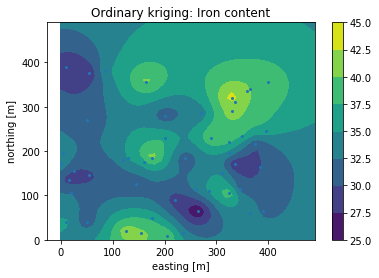

In [24]:
plt.figure()
plt.contourf(xg, yg, qe)
plt.xlabel("easting [m]")
plt.ylabel("northing [m]")
plt.title("Ordinary kriging: Iron content")
plt.colorbar()
plt.scatter(x,y, s=4)

The estimated error is the square root of the variance. Due to rounding errors a tiny variance my be calculated
with negative values so we need to clean this up before taking the root:

In [25]:
var[var<0]=0
rel_std=np.sqrt(var)/qe*100

An finally we can plot the relative error:

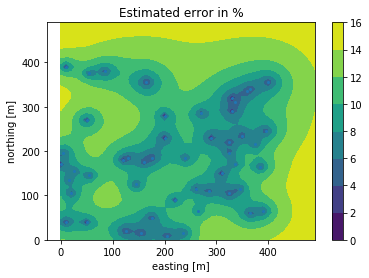

In [26]:
plt.figure()
plt.contourf(xg, yg, rel_std)
plt.xlabel("easting [m]")
plt.ylabel("northing [m]")
plt.title("Estimated error in %")
plt.colorbar()
plt.scatter(x,y, s=4)